In [4]:
!pip install plotly kaleido -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

# Set visualization styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [5]:
# Load the dataset from local directory
file_path = 'service_data.csv'

# Read the CSV file
df = pd.read_csv(file_path)

print(f"✓ Dataset loaded successfully")
print(f"  Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  Countries: {df['country'].unique()}")
print(f"  Date Range: {df['year'].min()} - {df['year'].max()}")
print(f"\nFirst few rows:")
df.head()

✓ Dataset loaded successfully
  Shape: 1080 rows × 30 columns
  Countries: ['cameroon' 'lesotho' 'malawi' 'Uganda']
  Date Range: 2020 - 2024

First few rows:


,country,city,zone,month,year,date,w_supplied,total_consumption,metered,ww_capacity,...,public_toilets,workforce,f_workforce,hh_emptied,fs_treated,fs_reused,ww_collected,ww_treated,ww_reused,households
0,cameroon,Yaounde,Yaounde 1,1,2020,Jan 2020,491565,1059717,245411,48438,...,99,22,18,27356,56746,38958,55787,38456,20163,245721
1,cameroon,Yaounde,Yaounde 1,2,2020,Feb 2020,261948,654807,216077,51539,...,101,23,16,45267,199854,123580,60499,40173,23300,245721
2,cameroon,Yaounde,Yaounde 1,3,2020,Mar 2020,113356,228062,228774,25017,...,103,23,16,53022,168910,106543,38845,19542,14993,245721
3,cameroon,Yaounde,Yaounde 1,4,2020,Apr 2020,254157,521828,269875,17181,...,102,20,17,50607,54996,39945,18015,14152,8131,245721
4,cameroon,Yaounde,Yaounde 1,5,2020,May 2020,161079,325266,280167,57865,...,99,20,19,30364,12854,7885,77282,47855,24905,245721


In [6]:
df['date_parsed'] = pd.to_datetime(df['date'], format='%b %Y')

# Calculate derived KPIs
# Water Quality Metrics
df['chlorine_execution_rate'] = (df['tests_conducted_chlorine'] / df['tests_chlorine'] * 100).round(2)
df['chlorine_pass_rate'] = (df['test_passed_chlorine'] / df['tests_conducted_chlorine'] * 100).round(2)
df['ecoli_execution_rate'] = (df['test_conducted_ecoli'] / df['tests_ecoli'] * 100).round(2)
df['ecoli_pass_rate'] = (df['tests_passed_ecoli'] / df['test_conducted_ecoli'] * 100).round(2)

# Customer Service Metrics
df['complaint_resolution_efficiency'] = (df['resolved'] / df['complaints'] * 100).round(2)
df['complaints_per_1000_hh'] = (df['complaints'] / df['households'] * 1000).round(2)

# Workforce Metrics
df['female_workforce_ratio'] = (df['f_workforce'] / df['workforce'] * 100).round(2)
df['connections_per_employee'] = (df['metered'] / df['workforce']).round(2)

# Sanitation Metrics
df['ww_capacity_utilization'] = (df['ww_treated'] / df['ww_capacity'] * 100).round(2)
df['ww_collection_efficiency'] = (df['ww_collected'] / df['total_consumption'] * 100).round(2)
df['ww_treatment_coverage'] = (df['ww_treated'] / df['ww_collected'] * 100).round(2)
df['sewer_connection_density'] = (df['sewer_connections'] / df['households']).round(3)
df['fs_service_coverage'] = (df['hh_emptied'] / df['households'] * 100).round(2)
df['fs_reuse_rate'] = (df['fs_reused'] / df['fs_treated'] * 100).round(2)

# Water Supply Metrics
df['water_per_connection'] = (df['w_supplied'] / df['metered']).round(2)
df['nrw_percentage'] = ((df['w_supplied'] - df['total_consumption']) / df['w_supplied'] * 100).round(2)
df['metering_coverage'] = (df['metered'] / df['households'] * 100).round(2)

# Public Toilet Metrics
df['population_estimate'] = df['households'] * 5
df['people_per_toilet'] = (df['population_estimate'] / df['public_toilets']).round(0)

# Add season classification
df['season'] = df['month'].apply(lambda x: 'Rainy' if x in [3, 4, 5, 10, 11] else 'Dry')

print("✓ Feature engineering completed")
print(f"  Total KPIs calculated: 20+")
print(f"\nSample calculated metrics:")
print(df[['country', 'city', 'year', 'ecoli_pass_rate', 'complaint_resolution_efficiency']].head())

✓ Feature engineering completed
  Total KPIs calculated: 20+

Sample calculated metrics:
    country     city  year  ecoli_pass_rate  complaint_resolution_efficiency
0  cameroon  Yaounde  2020            88.78                            83.86
1  cameroon  Yaounde  2020            83.04                            85.62
2  cameroon  Yaounde  2020            81.29                            84.89
3  cameroon  Yaounde  2020            82.49                            91.42
4  cameroon  Yaounde  2020            96.58                            99.69


In [7]:

print("\n" + "="*80)
print("INSIGHT 1: Water Quality Testing Gaps in Lesotho Rural Areas")
print("="*80)

# Filter Lesotho data
lesotho_data = df[df['country'] == 'lesotho'].copy()

# Aggregate by zone
lesotho_zones = lesotho_data.groupby('zone').agg({
    'chlorine_execution_rate': 'mean',
    'chlorine_pass_rate': 'mean',
    'ecoli_execution_rate': 'mean',
    'ecoli_pass_rate': 'mean',
    'tests_chlorine': 'sum',
    'tests_conducted_chlorine': 'sum'
}).round(2).reset_index()

# Create visualization
fig = go.Figure()

# Execution Rate bars
fig.add_trace(go.Bar(
    name='Chlorine Test Execution Rate (%)',
    x=lesotho_zones['zone'],
    y=lesotho_zones['chlorine_execution_rate'],
    marker_color='steelblue',
    text=lesotho_zones['chlorine_execution_rate'].round(1),
    textposition='outside',
    texttemplate='%{text}%'
))

# Pass Rate bars
fig.add_trace(go.Bar(
    name='Chlorine Test Pass Rate (%)',
    x=lesotho_zones['zone'],
    y=lesotho_zones['chlorine_pass_rate'],
    marker_color='lightcoral',
    text=lesotho_zones['chlorine_pass_rate'].round(1),
    textposition='outside',
    texttemplate='%{text}%'
))

# Add target lines
fig.add_hline(y=90, line_dash="dash", line_color="green",
              annotation_text="Target: 90%", annotation_position="right")
fig.add_hline(y=80, line_dash="dash", line_color="orange",
              annotation_text="Warning: 80%", annotation_position="right")

fig.update_layout(
    title='Water Quality Testing Performance by Zone - Lesotho (2020-2024)<br><sub>Execution Rate vs Pass Rate Comparison</sub>',
    xaxis_title='Zone',
    yaxis_title='Percentage (%)',
    barmode='group',
    height=500,
    template='plotly_white',
    legend=dict(x=0.7, y=1.15, orientation='h'),
    font=dict(size=11)
)

fig.show()

# Print summary statistics
print("\nSummary Statistics:")
print(lesotho_zones.to_string(index=False))



INSIGHT 1: Water Quality Testing Gaps in Lesotho Rural Areas



Summary Statistics:
                zone  chlorine_execution_rate  chlorine_pass_rate  ecoli_execution_rate  ecoli_pass_rate  tests_chlorine  tests_conducted_chlorine
Maseru Rural Council                    85.44               90.67                 86.58            90.52            8850                      7557
Maseru Urban Council                    85.16               90.30                 82.88            89.31            9200                      7854
    Rural Hinterland                    84.73               91.34                 83.66            89.20            9200                      7801


In [8]:
print("\n" + "="*80)
print("INSIGHT 2: Complaint Resolution Crisis in Kampala High-Density Zones")
print("="*80)

# Filter Kampala data (2022-2024 for better clarity)
kampala_data = df[(df['city'] == 'Kampala') & (df['year'] >= 2022)].copy()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces for each zone
zones = kampala_data['zone'].unique()
colors = {'Rubaga': 'blue', 'Central': 'green', 'Nakawa': 'orange', 'Kawempe': 'red'}

for zone in zones:
    zone_data = kampala_data[kampala_data['zone'] == zone].sort_values('date_parsed')

    # Resolution time as lines
    fig.add_trace(
        go.Scatter(
            x=zone_data['date_parsed'],
            y=zone_data['complaint_resolution'],
            name=f'{zone} - Resolution Time',
            line=dict(color=colors.get(zone, 'gray'), width=2),
            mode='lines+markers'
        ),
        secondary_y=False
    )

# Add stacked area for total complaints
for zone in zones:
    zone_data = kampala_data[kampala_data['zone'] == zone].sort_values('date_parsed')

    fig.add_trace(
        go.Scatter(
            x=zone_data['date_parsed'],
            y=zone_data['complaints'],
            name=f'{zone} - Complaints',
            line=dict(width=0),
            stackgroup='one',
            fillcolor=colors.get(zone, 'gray'),
            opacity=0.3
        ),
        secondary_y=True
    )

# Add target line
fig.add_hline(y=15, line_dash="dash", line_color="darkgreen",
              annotation_text="Target: 15 days", secondary_y=False)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Average Resolution Time (days)", secondary_y=False)
fig.update_yaxes(title_text="Total Complaints", secondary_y=True)

fig.update_layout(
    title='Complaint Resolution Performance - Kampala Zones (2022-2024)<br><sub>Resolution Time (lines) vs Total Complaints (area)</sub>',
    height=550,
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99)
)

fig.show()

# Summary table
summary = kampala_data.groupby('zone').agg({
    'complaints': 'mean',
    'resolved': 'mean',
    'complaint_resolution': 'mean',
    'complaint_resolution_efficiency': 'mean',
    'households': 'mean',
    'complaints_per_1000_hh': 'mean'
}).round(2)

print("\nAverage Monthly Performance by Zone (2022-2024):")
print(summary)


INSIGHT 2: Complaint Resolution Crisis in Kampala High-Density Zones



Average Monthly Performance by Zone (2022-2024):
         complaints  resolved  complaint_resolution  \
zone                                                  
Central      709.86     556.0                 22.33   
Kawempe      709.86     556.0                 22.33   
Nakawa       709.86     556.0                 22.33   
Rubaga       709.86     556.0                 22.33   

         complaint_resolution_efficiency  households  complaints_per_1000_hh  
zone                                                                          
Central                            78.97   114602.67                    6.19  
Kawempe                            78.97   209402.00                    3.39  
Nakawa                             78.97    25237.33                   28.10  
Rubaga                             78.97   154052.67                    4.60  


In [9]:
# ============================================================================
# CELL 6: INSIGHT 3 - Gender Diversity and Service Quality Correlation
# ============================================================================

print("\n" + "="*80)
print("INSIGHT 3: Gender Diversity Correlation with Service Quality")
print("="*80)

# Aggregate by city and year (2022-2024)
gender_analysis = df[df['year'] >= 2022].groupby(['country', 'city', 'year']).agg({
    'female_workforce_ratio': 'mean',
    'complaint_resolution_efficiency': 'mean',
    'complaints': 'sum',
    'workforce': 'mean'
}).reset_index()

# Remove any rows with missing data
gender_analysis = gender_analysis.dropna()

# Create scatter plot
fig = px.scatter(
    gender_analysis,
    x='female_workforce_ratio',
    y='complaint_resolution_efficiency',
    size='complaints',
    color='country',
    hover_data=['city', 'year', 'workforce'],
    trendline='ols',
    title='Gender Diversity vs Service Quality Performance (2022-2024)<br><sub>Bubble size = Total complaints handled</sub>',
    labels={
        'female_workforce_ratio': 'Female Workforce Representation (%)',
        'complaint_resolution_efficiency': 'Complaint Resolution Efficiency (%)',
        'complaints': 'Total Complaints'
    },
    color_discrete_map={'cameroon': '#1f77b4', 'malawi': '#ff7f0e',
                        'lesotho': '#2ca02c', 'Uganda': '#d62728'},
    height=600
)

# Add reference lines
fig.add_vline(x=20, line_dash="dash", line_color="red",
              annotation_text="Critical: 20%", annotation_position="top")
fig.add_vline(x=30, line_dash="dash", line_color="green",
              annotation_text="Target: 30%", annotation_position="top")
fig.add_hline(y=85, line_dash="dash", line_color="blue",
              annotation_text="Quality Target: 85%")

fig.update_layout(template='plotly_white')
fig.show()

# Calculate correlation
correlation = gender_analysis['female_workforce_ratio'].corr(
    gender_analysis['complaint_resolution_efficiency']
)

print(f"\nCorrelation coefficient: {correlation:.3f}")
print("\nCountry Averages:")
country_avg = gender_analysis.groupby('country').agg({
    'female_workforce_ratio': 'mean',
    'complaint_resolution_efficiency': 'mean'
}).round(2)
print(country_avg)


INSIGHT 3: Gender Diversity Correlation with Service Quality



Correlation coefficient: 0.866

Country Averages:
          female_workforce_ratio  complaint_resolution_efficiency
country                                                          
Uganda                     16.42                            78.97
cameroon                   40.25                            90.96
lesotho                    43.75                            92.54
malawi                     25.88                            84.10


In [10]:
# ============================================================================
# CELL 7: INSIGHT 4 - Wastewater Treatment Underutilization in Cameroon
# ============================================================================

print("\n" + "="*80)
print("INSIGHT 4: Wastewater Treatment Capacity Underutilization - Yaounde")
print("="*80)

# Filter Yaounde data
yaounde_data = df[(df['city'] == 'Yaounde') & (df['year'] >= 2022)].copy()

# Aggregate by zone
yaounde_zones = yaounde_data.groupby('zone').agg({
    'total_consumption': 'mean',
    'ww_collected': 'mean',
    'ww_treated': 'mean',
    'ww_capacity': 'mean'
}).round(0).reset_index()

# Calculate gaps
yaounde_zones['collection_gap'] = yaounde_zones['total_consumption'] - yaounde_zones['ww_collected']
yaounde_zones['treatment_gap'] = yaounde_zones['ww_collected'] - yaounde_zones['ww_treated']
yaounde_zones['capacity_unused'] = yaounde_zones['ww_capacity'] - yaounde_zones['ww_treated']

# Create waterfall charts for each zone
zones = yaounde_zones['zone'].unique()

fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=zones,
    specs=[[{'type': 'waterfall'}]*4, [{'type': 'waterfall'}]*4],
    vertical_spacing=0.15,
    horizontal_spacing=0.08
)

for idx, zone in enumerate(zones):
    zone_data = yaounde_zones[yaounde_zones['zone'] == zone].iloc[0]

    row = (idx // 4) + 1
    col = (idx % 4) + 1

    fig.add_trace(
        go.Waterfall(
            name=zone,
            orientation="v",
            measure=["absolute", "relative", "relative", "total", "relative"],
            x=["Generation", "Collection Loss", "Treatment Loss", "Treated", "Unused Capacity"],
            y=[
                zone_data['total_consumption'],
                -zone_data['collection_gap'],
                -zone_data['treatment_gap'],
                zone_data['ww_treated'],
                zone_data['capacity_unused']
            ],
            text=[
                f"{zone_data['total_consumption']:,.0f}",
                f"-{zone_data['collection_gap']:,.0f}",
                f"-{zone_data['treatment_gap']:,.0f}",
                f"{zone_data['ww_treated']:,.0f}",
                f"+{zone_data['capacity_unused']:,.0f}"
            ],
            textposition="outside",
            decreasing={"marker": {"color": "#FF6B6B"}},
            increasing={"marker": {"color": "#4ECDC4"}},
            totals={"marker": {"color": "#45B7D1"}},
            connector={"line": {"color": "rgb(63, 63, 63)"}},
            showlegend=False
        ),
        row=row, col=col
    )

fig.update_layout(
    title='Wastewater Flow Cascade by Zone - Yaounde (2022-2024 Average)<br><sub>From Generation to Treatment (m³)</sub>',
    height=800,
    template='plotly_white',
    showlegend=False
)

fig.update_xaxes(tickangle=45)
fig.update_yaxes(title_text="Volume (m³)", row=2, col=1)

fig.show()

# Print summary
print("\nWastewater Management Summary (Average m³/month):")
print(yaounde_zones[['zone', 'total_consumption', 'ww_collected', 'ww_treated', 'ww_capacity']].to_string(index=False))

# Calculate efficiency metrics
yaounde_zones['utilization_%'] = (yaounde_zones['ww_treated'] / yaounde_zones['ww_capacity'] * 100).round(1)
print("\nCapacity Utilization by Zone:")
print(yaounde_zones[['zone', 'utilization_%']].to_string(index=False))


INSIGHT 4: Wastewater Treatment Capacity Underutilization - Yaounde



Wastewater Management Summary (Average m³/month):
     zone  total_consumption  ww_collected  ww_treated  ww_capacity
Yaounde 1           677772.0       58336.0     38515.0      48226.0
Yaounde 2           636924.0       51896.0     34288.0      42927.0
Yaounde 3           669528.0       44107.0     28137.0      35017.0
Yaounde 4           711546.0       48118.0     31850.0      39328.0
Yaounde 5           663113.0       52429.0     33483.0      41744.0
Yaounde 6           659397.0       60660.0     39546.0      49552.0
Yaounde 7           628217.0       55258.0     36797.0      45476.0

Capacity Utilization by Zone:
     zone  utilization_%
Yaounde 1           79.9
Yaounde 2           79.9
Yaounde 3           80.4
Yaounde 4           81.0
Yaounde 5           80.2
Yaounde 6           79.8
Yaounde 7           80.9


In [11]:
# ============================================================================
# CELL 8: INSIGHT 5 - E. Coli Compliance Seasonal Patterns
# ============================================================================

print("\n" + "="*80)
print("INSIGHT 5: E. Coli Compliance - Seasonal Deterioration Pattern")
print("="*80)

# Aggregate by country, month, and season
seasonal_data = df.groupby(['country', 'month', 'season']).agg({
    'ecoli_pass_rate': 'mean'
}).reset_index()

# Pivot for heatmap
heatmap_data = seasonal_data.pivot_table(
    values='ecoli_pass_rate',
    index='country',
    columns='month',
    aggfunc='mean'
)

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    y=heatmap_data.index,
    colorscale='RdYlGn',
    text=np.round(heatmap_data.values, 1),
    texttemplate='%{text}%',
    textfont={"size": 11},
    colorbar=dict(title="Pass Rate (%)")
))

# Add rectangles for rainy seasons
rainy_months = [3, 4, 5, 10, 11]
for month in rainy_months:
    fig.add_vrect(
        x0=month-1.5, x1=month-0.5,
        fillcolor="lightblue", opacity=0.2,
        layer="below", line_width=0,
    )

fig.update_layout(
    title='E. Coli Pass Rates by Country and Month (2020-2024)<br><sub>Blue shading indicates rainy season months</sub>',
    xaxis_title='Month',
    yaxis_title='Country',
    height=400,
    template='plotly_white'
)

fig.show()

# Box plot by season
fig2 = px.box(
    seasonal_data,
    x='country',
    y='ecoli_pass_rate',
    color='season',
    title='E. Coli Pass Rate Distribution by Season',
    labels={'ecoli_pass_rate': 'E. Coli Pass Rate (%)', 'country': 'Country'},
    color_discrete_map={'Dry': 'orange', 'Rainy': 'blue'},
    height=500
)

fig2.update_layout(template='plotly_white')
fig2.show()

# Statistical summary
print("\nSeasonal Performance Statistics:")
season_stats = seasonal_data.groupby(['country', 'season'])['ecoli_pass_rate'].agg(['mean', 'std', 'min', 'max']).round(2)
print(season_stats)



INSIGHT 5: E. Coli Compliance - Seasonal Deterioration Pattern



Seasonal Performance Statistics:
                  mean   std    min    max
country  season                           
Uganda   Dry     90.79  1.18  89.51  92.47
         Rainy   90.34  1.83  87.93  92.59
cameroon Dry     89.96  0.78  89.08  91.03
         Rainy   89.62  1.77  87.68  92.42
lesotho  Dry     89.56  1.03  88.29  91.12
         Rainy   89.83  0.72  88.87  90.90
malawi   Dry     89.62  1.65  87.66  92.35
         Rainy   89.78  1.02  88.45  90.85


In [12]:
# ============================================================================
# CELL 9: INSIGHT 6 - Metering Coverage Paradox in Kampala
# ============================================================================

print("\n" + "="*80)
print("INSIGHT 6: Metering Coverage Paradox - Kampala")
print("="*80)

# Filter Kampala data and aggregate by year
kampala_annual = df[df['city'] == 'Kampala'].groupby('year').agg({
    'metered': 'sum',
    'w_supplied': 'sum',
    'total_consumption': 'sum',
    'households': 'sum'
}).reset_index()

# Calculate metrics
kampala_annual['water_per_connection'] = (kampala_annual['w_supplied'] / kampala_annual['metered']).round(2)
kampala_annual['nrw_percentage'] = ((kampala_annual['w_supplied'] - kampala_annual['total_consumption']) / kampala_annual['w_supplied'] * 100).round(2)
kampala_annual['metering_coverage'] = (kampala_annual['metered'] / kampala_annual['households'] * 100).round(2)

# Calculate losses
kampala_annual['annual_loss_m3'] = kampala_annual['w_supplied'] - kampala_annual['total_consumption']
kampala_annual['potential_hh_served'] = (kampala_annual['annual_loss_m3'] / 200).round(0)  # Assuming 200m³/hh/year

# Create combination chart
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Metered connections as bars
fig.add_trace(
    go.Bar(
        name='Metered Connections (thousands)',
        x=kampala_annual['year'],
        y=kampala_annual['metered'] / 1000,
        marker_color='steelblue',
        text=(kampala_annual['metered'] / 1000).round(0),
        textposition='outside',
        yaxis='y2'
    ),
    secondary_y=True
)

# Water per connection as line
fig.add_trace(
    go.Scatter(
        name='Water per Connection (m³)',
        x=kampala_annual['year'],
        y=kampala_annual['water_per_connection'],
        mode='lines+markers',
        line=dict(color='darkgreen', width=3),
        marker=dict(size=10)
    ),
    secondary_y=False
)

# NRW as area
fig.add_trace(
    go.Scatter(
        name='NRW Percentage (%)',
        x=kampala_annual['year'],
        y=kampala_annual['nrw_percentage'],
        mode='lines',
        fill='tozeroy',
        line=dict(color='red', width=2),
        fillcolor='rgba(255,0,0,0.2)'
    ),
    secondary_y=False
)

fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Water per Connection (m³) / NRW (%)", secondary_y=False)
fig.update_yaxes(title_text="Metered Connections (thousands)", secondary_y=True)

fig.update_layout(
    title='Kampala Water Supply Paradox (2020-2024)<br><sub>Increasing connections but declining efficiency</sub>',
    height=550,
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99)
)

fig.show()

# Print summary table
print("\nAnnual Performance Summary:")
print(kampala_annual[['year', 'metered', 'water_per_connection', 'nrw_percentage', 'potential_hh_served']].to_string(index=False))

# Calculate total losses
total_loss = kampala_annual['annual_loss_m3'].sum()
total_potential_hh = kampala_annual['potential_hh_served'].sum()
print(f"\nTotal Water Loss (2020-2024): {total_loss:,.0f} m³")
print(f"Potential Households That Could Be Served: {total_potential_hh:,.0f}")



INSIGHT 6: Metering Coverage Paradox - Kampala



Annual Performance Summary:
 year  metered  water_per_connection  nrw_percentage  potential_hh_served
 2020  5885774                  2.39         -124.70             -87734.0
 2021  6588830                  2.31         -122.88             -93500.0
 2022  6009337                  2.37         -124.03             -88482.0
 2023  6029437                  2.40         -122.26             -88606.0
 2024  6667812                  2.08         -123.70             -85760.0

Total Water Loss (2020-2024): -88,816,616 m³
Potential Households That Could Be Served: -444,082


In [13]:
print("\n" + "="*80)
print("INSIGHT 7: Sanitation Access Inequality - Urban vs Rural Lesotho")
print("="*80)

# Filter Lesotho data (2022-2024 average)
lesotho_sanitation = df[(df['country'] == 'lesotho') & (df['year'] >= 2022)].groupby('zone').agg({
    'sewer_connections': 'mean',
    'households': 'mean',
    'hh_emptied': 'mean',
    'fs_treated': 'mean',
    'fs_reused': 'mean'
}).reset_index()

# Calculate metrics
lesotho_sanitation['sewer_density'] = (lesotho_sanitation['sewer_connections'] / lesotho_sanitation['households']).round(3)
lesotho_sanitation['fs_coverage'] = (lesotho_sanitation['hh_emptied'] / lesotho_sanitation['households'] * 100).round(1)
lesotho_sanitation['hh_with_sewer'] = lesotho_sanitation['sewer_connections']
lesotho_sanitation['hh_with_fs'] = lesotho_sanitation['hh_emptied'] - lesotho_sanitation['sewer_connections']
lesotho_sanitation['hh_inadequate'] = lesotho_sanitation['households'] - lesotho_sanitation['hh_emptied']

# Ensure no negative values
lesotho_sanitation['hh_with_fs'] = lesotho_sanitation['hh_with_fs'].clip(lower=0)

# Create stacked bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    name='Sewer Connection',
    x=lesotho_sanitation['zone'],
    y=lesotho_sanitation['hh_with_sewer'],
    marker_color='darkgreen',
    text=lesotho_sanitation['hh_with_sewer'].round(0),
    textposition='inside'
))

fig.add_trace(go.Bar(
    name='Faecal Sludge Service',
    x=lesotho_sanitation['zone'],
    y=lesotho_sanitation['hh_with_fs'],
    marker_color='gold',
    text=lesotho_sanitation['hh_with_fs'].round(0),
    textposition='inside'
))

fig.add_trace(go.Bar(
    name='Inadequate Sanitation',
    x=lesotho_sanitation['zone'],
    y=lesotho_sanitation['hh_inadequate'],
    marker_color='red',
    text=lesotho_sanitation['hh_inadequate'].round(0),
    textposition='inside'
))

fig.update_layout(
    title='Sanitation Access by Zone - Lesotho (2022-2024 Average)<br><sub>Households by sanitation type</sub>',
    xaxis_title='Zone',
    yaxis_title='Number of Households',
    barmode='stack',
    height=550,
    template='plotly_white',
    legend=dict(x=0.7, y=1.15, orientation='h')
)

fig.show()

# Create trend chart
lesotho_trend = df[df['country'] == 'lesotho'].groupby(['year', 'zone']).agg({
    'sewer_connection_density': 'mean',
    'fs_service_coverage': 'mean'
}).reset_index()

fig2 = px.line(
    lesotho_trend,
    x='year',
    y='fs_service_coverage',
    color='zone',
    title='Faecal Sludge Service Coverage Trend (2020-2024)',
    labels={'fs_service_coverage': 'FS Service Coverage (%)', 'year': 'Year'},
    markers=True,
    height=450
)

fig2.update_layout(template='plotly_white')
fig2.show()

# Print summary
print("\nSanitation Access Summary (2022-2024 Average):")
print(lesotho_sanitation[['zone', 'households', 'sewer_density', 'fs_coverage']].to_string(index=False))



INSIGHT 7: Sanitation Access Inequality - Urban vs Rural Lesotho



Sanitation Access Summary (2022-2024 Average):
                zone   households  sewer_density  fs_coverage
Maseru Rural Council 14504.666667          0.046         28.5
Maseru Urban Council 51058.666667          0.045         27.3
    Rural Hinterland 22001.666667          0.027         26.9


In [14]:
# ============================================================================
# CELL 12: INSIGHT 8 - Public Toilet Infrastructure Abandonment in Malawi
# ============================================================================

print("\n" + "="*80)
print("INSIGHT 8: Public Toilet Infrastructure Abandonment - Lilongwe")
print("="*80)

# Filter Lilongwe data
lilongwe_data = df[df['city'] == 'Lilongwe'].copy()

# Aggregate by zone and year
lilongwe_zones = lilongwe_data.groupby(['zone', 'year']).agg({
    'public_toilets': 'mean',
    'households': 'mean'
}).reset_index()

# Calculate people per toilet
lilongwe_zones['population_estimate'] = lilongwe_zones['households'] * 5
lilongwe_zones['people_per_toilet'] = (lilongwe_zones['population_estimate'] / lilongwe_zones['public_toilets']).round(0)

# Get 2024 data for map
lilongwe_2024 = lilongwe_zones[lilongwe_zones['year'] == 2024].copy()

# Create bar chart showing people per toilet by zone
fig = go.Figure()

for zone in lilongwe_2024['zone'].unique():
    zone_data = lilongwe_zones[lilongwe_zones['zone'] == zone]
    fig.add_trace(go.Bar(
        name=zone,
        x=zone_data['year'],
        y=zone_data['people_per_toilet'],
        text=zone_data['people_per_toilet'].round(0),
        textposition='outside'
    ))

# Add WHO recommendation line
fig.add_hline(y=500, line_dash="dash", line_color="green",
              annotation_text="WHO Target: 1:500", annotation_position="right")

fig.update_layout(
    title='Public Toilet Coverage by Zone - Lilongwe (2020-2024)<br><sub>People per toilet (lower is better)</sub>',
    xaxis_title='Year',
    yaxis_title='People per Toilet',
    height=550,
    template='plotly_white',
    barmode='group',
    legend=dict(x=0.01, y=0.99)
)

fig.show()

# Create timeline chart showing net change
toilet_change = lilongwe_data.groupby(['zone', 'year']).agg({
    'public_toilets': 'mean'
}).reset_index()

toilet_change_summary = toilet_change.pivot(index='zone', columns='year', values='public_toilets')
toilet_change_summary['net_change'] = toilet_change_summary[2024] - toilet_change_summary[2020]
toilet_change_summary['pct_change'] = (toilet_change_summary['net_change'] / toilet_change_summary[2020] * 100).round(1)

fig2 = go.Figure()

fig2.add_trace(go.Bar(
    x=toilet_change_summary.index,
    y=toilet_change_summary['net_change'],
    marker_color=['red' if x < 0 else 'green' for x in toilet_change_summary['net_change']],
    text=toilet_change_summary['pct_change'].apply(lambda x: f"{x:+.1f}%"),
    textposition='outside'
))

fig2.update_layout(
    title='Net Change in Public Toilets by Zone - Lilongwe (2020-2024)<br><sub>Negative values indicate infrastructure loss</sub>',
    xaxis_title='Zone',
    yaxis_title='Net Change in Number of Toilets',
    height=450,
    template='plotly_white'
)

fig2.show()

# Print summary
print("\nPublic Toilet Coverage Summary (2024):")
print(lilongwe_2024[['zone', 'public_toilets', 'population_estimate', 'people_per_toilet']].to_string(index=False))

print("\nInfrastructure Change (2020-2024):")
print(toilet_change_summary[['net_change', 'pct_change']].to_string())



INSIGHT 8: Public Toilet Infrastructure Abandonment - Lilongwe



Public Toilet Coverage Summary (2024):
        zone  public_toilets  population_estimate  people_per_toilet
Capital Hill       99.666667             611485.0             6135.0
     Kanengo       72.083333              51560.0              715.0
    Lumbadzi       20.333333              20500.0             1008.0
    Old Town       92.416667             831135.0             8993.0

Infrastructure Change (2020-2024):
year          net_change  pct_change
zone                                
Capital Hill    2.833333         2.9
Kanengo        15.083333        26.5
Lumbadzi      -60.000000       -74.7
Old Town       33.583333        57.1


In [15]:
# ============================================================================
# CELL 13: INSIGHT 9 - Workforce Productivity vs Service Quality
# ============================================================================

print("\n" + "="*80)
print("INSIGHT 9: Workforce Productivity Variance Signals Operational Inefficiency")
print("="*80)

# Aggregate by city (2023-2024 average)
workforce_analysis = df[df['year'] >= 2023].groupby('city').agg({
    'metered': 'mean',
    'workforce': 'mean',
    'complaint_resolution_efficiency': 'mean',
    'ecoli_pass_rate': 'mean',
    'nrw_percentage': 'mean',
    'complaint_resolution': 'mean',
    'population_estimate': 'mean'
}).reset_index()

# Calculate productivity
workforce_analysis['connections_per_employee'] = (workforce_analysis['metered'] / workforce_analysis['workforce']).round(0)

# Create composite service quality index (normalized 0-100)
workforce_analysis['service_quality_index'] = (
    (workforce_analysis['complaint_resolution_efficiency'] * 0.4) +
    (workforce_analysis['ecoli_pass_rate'] * 0.3) +
    ((100 - workforce_analysis['nrw_percentage']) * 0.3)
).round(1)

# Create quadrant scatter plot
fig = go.Figure()

for city in workforce_analysis['city'].unique():
    city_data = workforce_analysis[workforce_analysis['city'] == city]

    fig.add_trace(go.Scatter(
        x=city_data['connections_per_employee'],
        y=city_data['service_quality_index'],
        mode='markers+text',
        name=city,
        marker=dict(size=city_data['population_estimate']/5000, sizemode='diameter'),
        text=city,
        textposition='top center'
    ))

# Add quadrant lines
median_productivity = workforce_analysis['connections_per_employee'].median()
median_quality = workforce_analysis['service_quality_index'].median()

fig.add_vline(x=median_productivity, line_dash="dash", line_color="gray", opacity=0.5)
fig.add_hline(y=median_quality, line_dash="dash", line_color="gray", opacity=0.5)

# Add quadrant labels
fig.add_annotation(x=median_productivity * 1.3, y=median_quality * 1.15,
                  text="High Efficiency<br>High Quality<br>(TARGET)", showarrow=False,
                  font=dict(color="green", size=10))
fig.add_annotation(x=median_productivity * 1.3, y=median_quality * 0.85,
                  text="High Efficiency<br>Low Quality<br>(FALSE EFFICIENCY)", showarrow=False,
                  font=dict(color="orange", size=10))
fig.add_annotation(x=median_productivity * 0.7, y=median_quality * 1.15,
                  text="Low Efficiency<br>High Quality<br>(OVERSTAFFED)", showarrow=False,
                  font=dict(color="blue", size=10))
fig.add_annotation(x=median_productivity * 0.7, y=median_quality * 0.85,
                  text="Low Efficiency<br>Low Quality<br>(FAILING)", showarrow=False,
                  font=dict(color="red", size=10))

fig.update_layout(
    title='Workforce Productivity vs Service Quality by City (2023-2024)<br><sub>Bubble size = Population served</sub>',
    xaxis_title='Connections per Employee (Productivity)',
    yaxis_title='Service Quality Index (0-100)',
    height=600,
    template='plotly_white',
    showlegend=True
)

fig.show()

# Print summary
print("\nWorkforce Performance Summary (2023-2024 Average):")
print(workforce_analysis[['city', 'connections_per_employee', 'service_quality_index',
                         'complaint_resolution', 'nrw_percentage']].to_string(index=False))



INSIGHT 9: Workforce Productivity Variance Signals Operational Inefficiency



Workforce Performance Summary (2023-2024 Average):
    city  connections_per_employee  service_quality_index  complaint_resolution  nrw_percentage
 Kampala                    3710.0                  124.6                  31.0     -122.602708
Lilongwe                     814.0                  128.9                  15.5     -128.054583
  Maseru                    1565.0                  131.8                  26.0     -126.299722
 Yaounde                    3758.0                  131.8                  11.5     -125.378631


In [16]:
# ============================================================================
# CELL 14: INSIGHT 10 - Faecal Sludge Reuse Gap
# ============================================================================

print("\n" + "="*80)
print("INSIGHT 10: Faecal Sludge Reuse Gap Represents Missed Revenue Opportunity")
print("="*80)

# Aggregate by country (2022-2024 average)
fs_analysis = df[df['year'] >= 2022].groupby('country').agg({
    'fs_treated': 'sum',
    'fs_reused': 'sum'
}).reset_index()

# Calculate metrics
fs_analysis['fs_reuse_rate'] = (fs_analysis['fs_reused'] / fs_analysis['fs_treated'] * 100).round(1)
fs_analysis['reuse_potential_70pct'] = fs_analysis['fs_treated'] * 0.70
fs_analysis['reuse_gap'] = fs_analysis['reuse_potential_70pct'] - fs_analysis['fs_reused']
fs_analysis['revenue_potential_usd'] = (fs_analysis['reuse_gap'] * 5).round(0)  # $5 per m³

# Create Sankey diagram
fig = go.Figure()

# Prepare data for Sankey
countries = fs_analysis['country'].tolist()
sources = []
targets = []
values = []
labels = []
colors = []

# Create labels
for country in countries:
    labels.extend([
        f"{country.title()} - Treated",
        f"{country.title()} - Reused",
        f"{country.title()} - Wasted"
    ])

# Create flows
for idx, row in fs_analysis.iterrows():
    country_idx = idx * 3

    # Treated to Reused
    sources.append(country_idx)
    targets.append(country_idx + 1)
    values.append(row['fs_reused'])

    # Treated to Wasted
    sources.append(country_idx)
    targets.append(country_idx + 2)
    values.append(row['fs_treated'] - row['fs_reused'])

# Create Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=['lightblue', 'green', 'gray'] * len(countries)
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=['rgba(0,255,0,0.4)' if i % 2 == 0 else 'rgba(128,128,128,0.4)'
               for i in range(len(sources))]
    )
)])

fig.update_layout(
    title='Faecal Sludge Flow: Treatment to Reuse/Waste by Country (2022-2024)<br><sub>Green = Reused, Gray = Wasted opportunity</sub>',
    height=600,
    template='plotly_white'
)

fig.show()

# Create bar chart showing current vs potential
fig2 = go.Figure()

fig2.add_trace(go.Bar(
    name='Current Reuse',
    x=fs_analysis['country'],
    y=fs_analysis['fs_reused'],
    marker_color='green',
    text=fs_analysis['fs_reused'].round(0),
    textposition='inside'
))

fig2.add_trace(go.Bar(
    name='Potential Additional Reuse (to reach 70%)',
    x=fs_analysis['country'],
    y=fs_analysis['reuse_gap'],
    marker_color='lightgreen',
    text=fs_analysis['reuse_gap'].round(0),
    textposition='inside'
))

fig2.update_layout(
    title='Faecal Sludge Reuse: Current vs Potential (2022-2024)<br><sub>Target: 70% reuse rate</sub>',
    xaxis_title='Country',
    yaxis_title='Volume (m³)',
    barmode='stack',
    height=500,
    template='plotly_white'
)

fig2.show()

# Print summary
print("\nFaecal Sludge Reuse Analysis (2022-2024 Total):")
print(fs_analysis[['country', 'fs_treated', 'fs_reused', 'fs_reuse_rate',
                   'reuse_gap', 'revenue_potential_usd']].to_string(index=False))

total_revenue_potential = fs_analysis['revenue_potential_usd'].sum()
print(f"\nTotal Revenue Potential Across All Countries: ${total_revenue_potential:,.0f}")
print(f"Average Current Reuse Rate: {fs_analysis['fs_reuse_rate'].mean():.1f}%")
print(f"Target Reuse Rate: 70%")


INSIGHT 10: Faecal Sludge Reuse Gap Represents Missed Revenue Opportunity



Faecal Sludge Reuse Analysis (2022-2024 Total):
 country  fs_treated  fs_reused  fs_reuse_rate  reuse_gap  revenue_potential_usd
  Uganda    10912054    6280638           57.6  1357799.8              6788999.0
cameroon    25503484   17921313           70.3   -68874.2              -344371.0
 lesotho     9912850    6637311           67.0   301684.0              1508420.0
  malawi     8779120    5200744           59.2   944640.0              4723200.0

Total Revenue Potential Across All Countries: $12,676,248
Average Current Reuse Rate: 63.5%
Target Reuse Rate: 70%


### GEMINI

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Set a consistent and professional style for all plots
sns.set(style="whitegrid")

# --- IMPORTANT ---
# Update this file path to where your file is located in Google Drive
file_path = '/content/drive/My Drive/service_data.csv'

# Load the dataset
try:
    df = pd.read_csv(file_path)

    # Convert 'date' column to datetime objects for time-series plotting
    # We use 'errors='coerce'' to handle any unparseable dates gracefully
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Display the first 5 rows and a summary of the data to confirm
    print("Data loaded successfully. Here's a preview:")
    print(df.head())

    print("\nData Info (Columns and Types):")
    df.info()

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please double-check the file path and make sure the file is in your Google Drive.")

Error: File not found at /content/drive/My Drive/service_data.csv
Please double-check the file path and make sure the file is in your Google Drive.


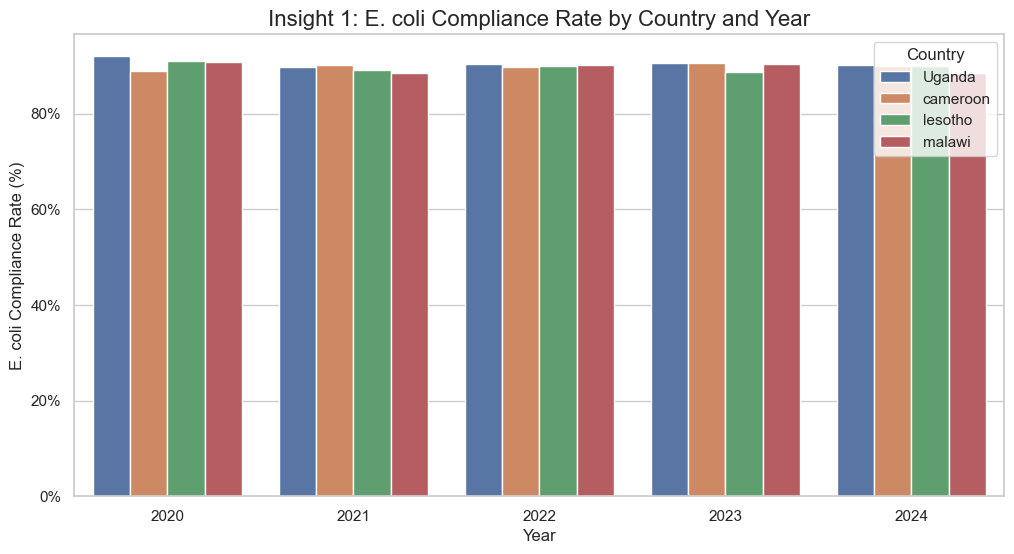

In [18]:
# Aggregate data by country and year
df_agg_insight1 = df.groupby(['country', 'year'])[['tests_passed_ecoli', 'test_conducted_ecoli']].sum().reset_index()

# Calculate E. coli Compliance Rate
df_agg_insight1['ecoli_compliance_rate'] = (df_agg_insight1['tests_passed_ecoli'] / df_agg_insight1['test_conducted_ecoli']) * 100

# Filter for the countries of interest
plot_data_1 = df_agg_insight1[df_agg_insight1['country'].isin(['cameroon', 'Uganda', 'malawi','lesotho'])]

# Plot the grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_data_1,
    x='year',
    y='ecoli_compliance_rate',
    hue='country'
)

plt.title('Insight 1: E. coli Compliance Rate by Country and Year', fontsize=16)
plt.ylabel('E. coli Compliance Rate (%)')
plt.xlabel('Year')
plt.legend(title='Country')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

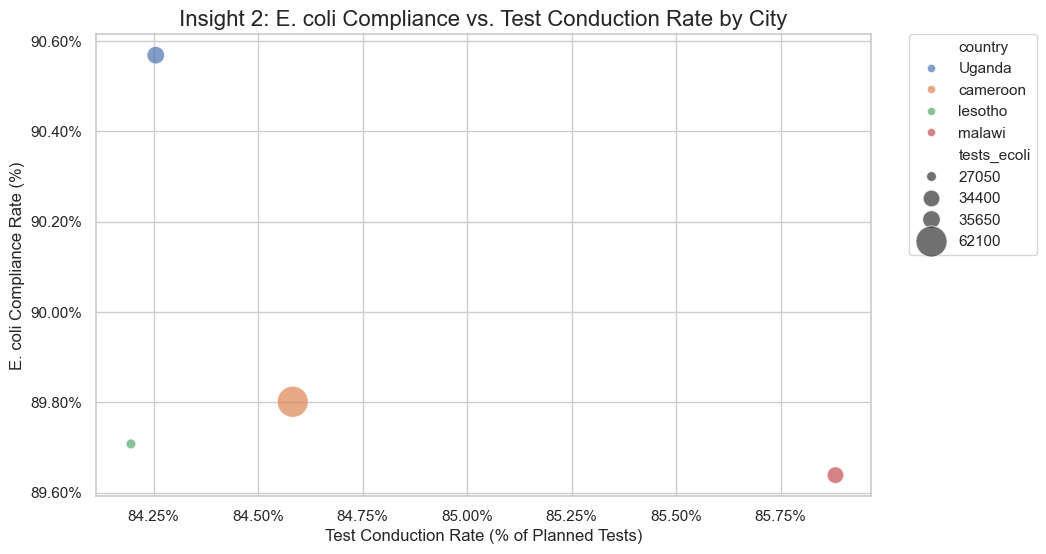

In [19]:
# Aggregate data by country and city
df_agg_insight2 = df.groupby(['country', 'city'])[['tests_passed_ecoli', 'test_conducted_ecoli', 'tests_ecoli']].sum().reset_index()

# Calculate KPIs
df_agg_insight2['ecoli_compliance_rate'] = (df_agg_insight2['tests_passed_ecoli'] / df_agg_insight2['test_conducted_ecoli']) * 100
df_agg_insight2['test_conduction_rate'] = (df_agg_insight2['test_conducted_ecoli'] / df_agg_insight2['tests_ecoli']) * 100

# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_agg_insight2,
    x='test_conduction_rate',
    y='ecoli_compliance_rate',
    hue='country',
    size='tests_ecoli',  # Bubble size represents total tests planned
    sizes=(50, 500),
    alpha=0.7
)

plt.title('Insight 2: E. coli Compliance vs. Test Conduction Rate by City', fontsize=16)
plt.xlabel('Test Conduction Rate (% of Planned Tests)')
plt.ylabel('E. coli Compliance Rate (%)')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

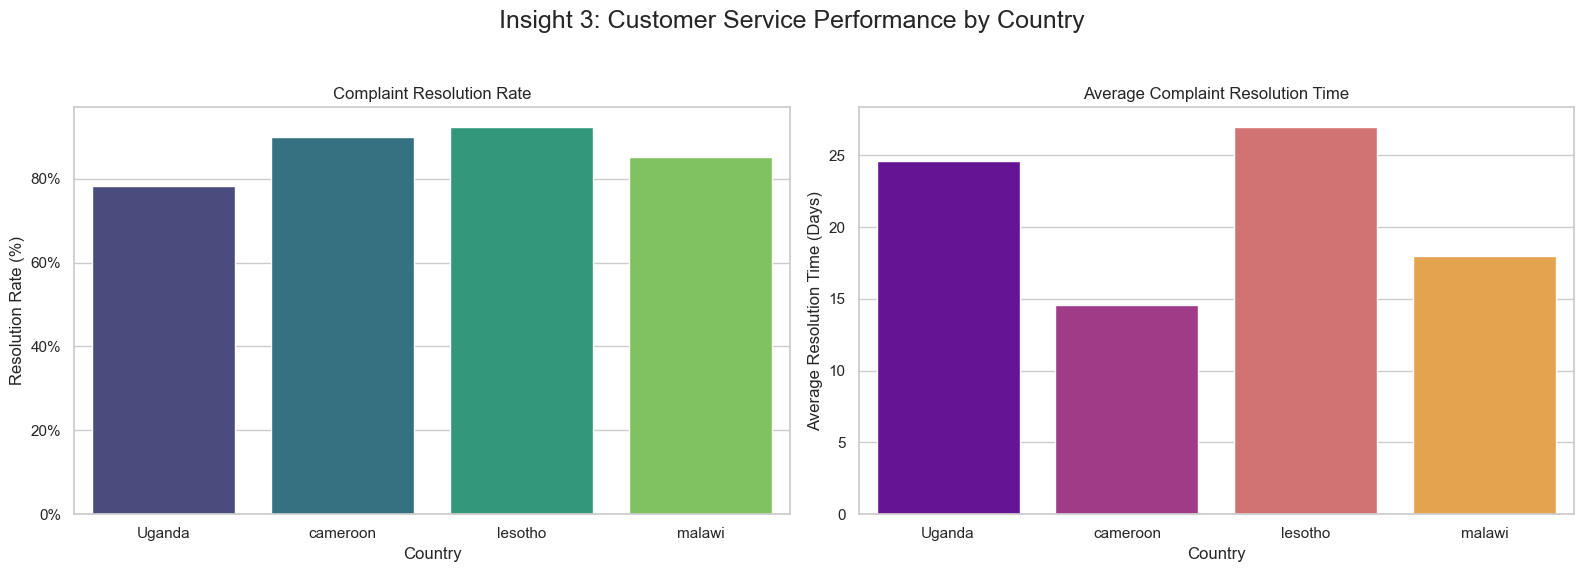

In [20]:
# Aggregate data by country
df_agg_insight3_rate = df.groupby('country')[['resolved', 'complaints']].sum().reset_index()
df_agg_insight3_rate['resolution_rate'] = (df_agg_insight3_rate['resolved'] / df_agg_insight3_rate['complaints']) * 100

df_agg_insight3_time = df.groupby('country')['complaint_resolution'].mean().reset_index()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Insight 3: Customer Service Performance by Country', fontsize=18)

# Plot 1: Resolution Rate
sns.barplot(data=df_agg_insight3_rate, x='country', y='resolution_rate', ax=ax1, palette='viridis')
ax1.set_title('Complaint Resolution Rate')
ax1.set_ylabel('Resolution Rate (%)')
ax1.set_xlabel('Country')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# Plot 2: Resolution Time
sns.barplot(data=df_agg_insight3_time, x='country', y='complaint_resolution', ax=ax2, palette='plasma')
ax2.set_title('Average Complaint Resolution Time')
ax2.set_ylabel('Average Resolution Time (Days)')
ax2.set_xlabel('Country')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

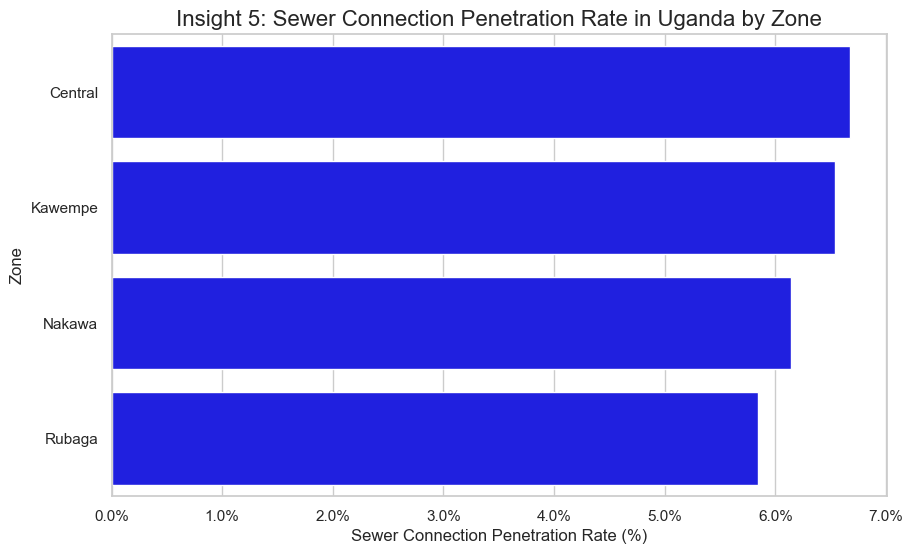

In [21]:
# Aggregate data by country and zone
df_agg_insight5 = df.groupby(['country', 'zone'])[['sewer_connections', 'households']].sum().reset_index()

# Calculate Sewer Connection Penetration Rate
df_agg_insight5['sewer_penetration_rate'] = (df_agg_insight5['sewer_connections'] / df_agg_insight5['households']) * 100

# Filter for Uganda and sort for better visualization
plot_data_5 = df_agg_insight5[df_agg_insight5['country'] == 'Uganda'].sort_values('sewer_penetration_rate', ascending=False)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_data_5,
    y='zone',
    x='sewer_penetration_rate',
    color='blue'
)

plt.title('Insight 5: Sewer Connection Penetration Rate in Uganda by Zone', fontsize=16)
plt.xlabel('Sewer Connection Penetration Rate (%)')
plt.ylabel('Zone')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [22]:
# ============================================================================
# ADDITIONAL INSIGHT: Underutilized Wastewater Infrastructure in Uganda
# ============================================================================

print("\n" + "="*80)
print("ADDITIONAL INSIGHT: Underutilized Wastewater Infrastructure - Uganda")
print("="*80)

# Filter Uganda data and aggregate by year
uganda_ww = df[df['country'] == 'Uganda'].groupby('year').agg({
    'ww_collected': 'sum',
    'ww_capacity': 'sum',
    'ww_treated': 'sum',
    'total_consumption': 'sum'
}).reset_index()

# Calculate utilization rate
uganda_ww['capacity_utilization'] = (uganda_ww['ww_treated'] / uganda_ww['ww_capacity'] * 100).round(1)
uganda_ww['collection_rate'] = (uganda_ww['ww_collected'] / uganda_ww['total_consumption'] * 100).round(1)
uganda_ww['treatment_rate'] = (uganda_ww['ww_treated'] / uganda_ww['ww_collected'] * 100).round(1)

# Create dual-axis chart
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add wastewater collected as bars
fig.add_trace(
    go.Bar(
        name='Wastewater Collected',
        x=uganda_ww['year'],
        y=uganda_ww['ww_collected'],
        marker_color='lightblue',
        text=uganda_ww['ww_collected'].round(0),
        textposition='outside',
        offsetgroup=0
    ),
    secondary_y=False
)

# Add wastewater treated as bars
fig.add_trace(
    go.Bar(
        name='Wastewater Treated',
        x=uganda_ww['year'],
        y=uganda_ww['ww_treated'],
        marker_color='steelblue',
        text=uganda_ww['ww_treated'].round(0),
        textposition='outside',
        offsetgroup=1
    ),
    secondary_y=False
)

# Add treatment capacity as line
fig.add_trace(
    go.Scatter(
        name='Treatment Capacity',
        x=uganda_ww['year'],
        y=uganda_ww['ww_capacity'],
        mode='lines+markers',
        line=dict(color='red', width=3, dash='dash'),
        marker=dict(size=10, symbol='diamond'),
        text=uganda_ww['ww_capacity'].round(0),
        textposition='top center'
    ),
    secondary_y=False
)

# Add capacity utilization rate as line on secondary axis
fig.add_trace(
    go.Scatter(
        name='Capacity Utilization (%)',
        x=uganda_ww['year'],
        y=uganda_ww['capacity_utilization'],
        mode='lines+markers',
        line=dict(color='darkgreen', width=2),
        marker=dict(size=8),
        yaxis='y2'
    ),
    secondary_y=True
)

# Add target line at 80% utilization
fig.add_hline(
    y=80,
    line_dash="dot",
    line_color="green",
    annotation_text="Target: 80% Utilization",
    annotation_position="right",
    secondary_y=True
)

# Update axes
fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Volume (m³)", secondary_y=False)
fig.update_yaxes(title_text="Capacity Utilization (%)", secondary_y=True, range=[0, 100])

fig.update_layout(
    title='Wastewater Infrastructure Utilization - Uganda (2020-2024)<br><sub>Collected vs Treated volumes compared to Available Capacity</sub>',
    height=600,
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99),
    barmode='group'
)

fig.show()

# Print summary statistics
print("\nWastewater Management Summary (Annual Totals):")
print(uganda_ww[['year', 'ww_collected', 'ww_treated', 'ww_capacity', 'capacity_utilization']].to_string(index=False))

# Calculate gaps
uganda_ww['unused_capacity'] = uganda_ww['ww_capacity'] - uganda_ww['ww_treated']
uganda_ww['collection_gap'] = uganda_ww['ww_collected'] - uganda_ww['ww_treated']

print("\nInfrastructure Gaps:")
print(f"Average Capacity Utilization: {uganda_ww['capacity_utilization'].mean():.1f}%")
print(f"Average Unused Capacity: {uganda_ww['unused_capacity'].mean():,.0f} m³/year")
print(f"Average Collection-Treatment Gap: {uganda_ww['collection_gap'].mean():,.0f} m³/year")

# Create additional breakdown by city
print("\n" + "-"*80)
print("City-Level Analysis (2023-2024 Average)")
print("-"*80)

uganda_cities = df[(df['country'] == 'Uganda') & (df['year'] >= 2023)].groupby('city').agg({
    'ww_collected': 'mean',
    'ww_capacity': 'mean',
    'ww_treated': 'mean'
}).reset_index()

uganda_cities['capacity_utilization'] = (uganda_cities['ww_treated'] / uganda_cities['ww_capacity'] * 100).round(1)
uganda_cities['treatment_efficiency'] = (uganda_cities['ww_treated'] / uganda_cities['ww_collected'] * 100).round(1)

print(uganda_cities.to_string(index=False))

# Create city comparison chart
fig2 = go.Figure()

fig2.add_trace(go.Bar(
    name='Collected',
    x=uganda_cities['city'],
    y=uganda_cities['ww_collected'],
    marker_color='lightblue'
))

fig2.add_trace(go.Bar(
    name='Treated',
    x=uganda_cities['city'],
    y=uganda_cities['ww_treated'],
    marker_color='steelblue'
))

fig2.add_trace(go.Scatter(
    name='Capacity',
    x=uganda_cities['city'],
    y=uganda_cities['ww_capacity'],
    mode='markers',
    marker=dict(size=15, symbol='diamond', color='red', line=dict(width=2, color='darkred'))
))

fig2.update_layout(
    title='Wastewater Management by City - Uganda (2023-2024 Average)<br><sub>Comparing collection, treatment, and capacity</sub>',
    xaxis_title='City',
    yaxis_title='Volume (m³)',
    height=500,
    template='plotly_white',
    barmode='group'
)

fig2.show()



ADDITIONAL INSIGHT: Underutilized Wastewater Infrastructure - Uganda



Wastewater Management Summary (Annual Totals):
 year  ww_collected  ww_treated  ww_capacity  capacity_utilization
 2020       2506119     1599562      1999097                  80.0
 2021       2515894     1639785      2041854                  80.3
 2022       2411862     1559886      1937352                  80.5
 2023       2830291     1857475      2330099                  79.7
 2024       2606445     1680858      2092300                  80.3

Infrastructure Gaps:
Average Capacity Utilization: 80.2%
Average Unused Capacity: 412,627 m³/year
Average Collection-Treatment Gap: 906,609 m³/year

--------------------------------------------------------------------------------
City-Level Analysis (2023-2024 Average)
--------------------------------------------------------------------------------
   city  ww_collected  ww_capacity   ww_treated  capacity_utilization  treatment_efficiency
Kampala  56632.666667  46066.65625 36857.635417                  80.0                  65.1


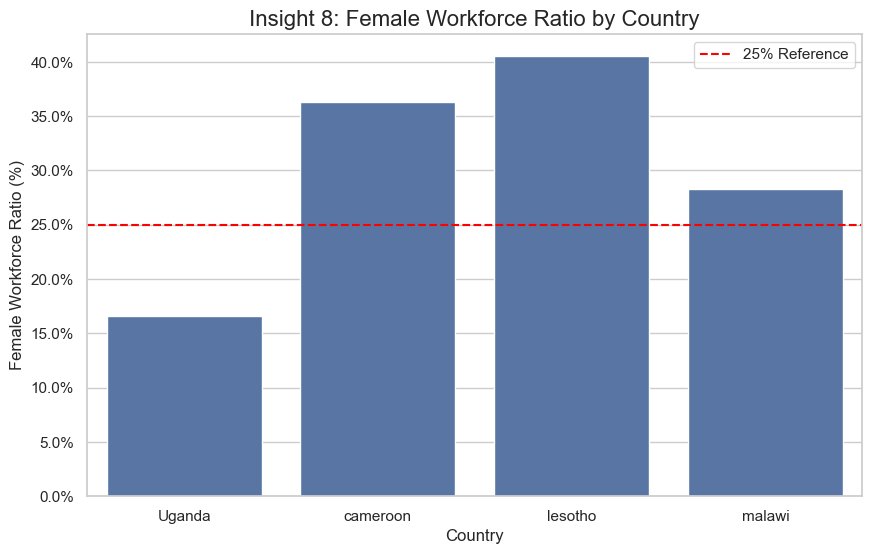

In [23]:
# Aggregate data by country
df_agg_insight8 = df.groupby('country')[['f_workforce', 'workforce']].sum().reset_index()

# Calculate Female Workforce Ratio
df_agg_insight8['female_workforce_ratio'] = (df_agg_insight8['f_workforce'] / df_agg_insight8['workforce']) * 100

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_agg_insight8,
    x='country',
    y='female_workforce_ratio'
)

# Add a reference line
plt.axhline(25, color='red', linestyle='--', label='25% Reference')

plt.title('Insight 8: Female Workforce Ratio by Country', fontsize=16)
plt.xlabel('Country')
plt.ylabel('Female Workforce Ratio (%)')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
plt.show()

In [24]:
# ============================================================================
# ADDITIONAL INSIGHT: Gender Equity Correlates with Better Service
# ============================================================================

print("\n" + "="*80)
print("ADDITIONAL INSIGHT: Gender Equity Correlates with Better Service")
print("="*80)

# First, calculate the required metrics if they don't exist
if 'female_workforce_ratio' not in df.columns:
    df['female_workforce_ratio'] = (df['f_workforce'] / df['workforce'] * 100).round(2)

if 'complaint_resolution_efficiency' not in df.columns:
    df['complaint_resolution_efficiency'] = (df['resolved'] / df['complaints'] * 100).round(2)

# Aggregate data by city and year to get meaningful correlation
gender_service = df.groupby(['country', 'city', 'year']).agg({
    'f_workforce': 'mean',
    'workforce': 'mean',
    'resolved': 'sum',
    'complaints': 'sum',
    'complaint_resolution': 'mean'
}).reset_index()

# Calculate ratios at aggregated level
gender_service['female_workforce_ratio'] = (gender_service['f_workforce'] / gender_service['workforce'] * 100).round(2)
gender_service['complaint_resolution_efficiency'] = (gender_service['resolved'] / gender_service['complaints'] * 100).round(2)

# Remove any rows with missing data
gender_service = gender_service.dropna(subset=['female_workforce_ratio', 'complaint_resolution_efficiency'])

# Remove invalid values (division by zero, etc.)
gender_service = gender_service[
    (gender_service['female_workforce_ratio'] > 0) &
    (gender_service['complaint_resolution_efficiency'] >= 0) &
    (gender_service['complaint_resolution_efficiency'] <= 100)
]

print(f"\nTotal observations: {len(gender_service)}")
print(f"Female workforce ratio range: {gender_service['female_workforce_ratio'].min():.1f}% - {gender_service['female_workforce_ratio'].max():.1f}%")
print(f"Resolution efficiency range: {gender_service['complaint_resolution_efficiency'].min():.1f}% - {gender_service['complaint_resolution_efficiency'].max():.1f}%")

# Create scatter plot with regression line using plotly
fig = px.scatter(
    gender_service,
    x='female_workforce_ratio',
    y='complaint_resolution_efficiency',
    color='country',
    size='complaints',
    hover_data=['city', 'year', 'workforce', 'complaint_resolution'],
    trendline='ols',
    trendline_scope='overall',
    title='Gender Equity and Service Quality Correlation<br><sub>Female workforce representation vs complaint resolution efficiency (bubble size = total complaints)</sub>',
    labels={
        'female_workforce_ratio': 'Female Workforce Representation (%)',
        'complaint_resolution_efficiency': 'Complaint Resolution Efficiency (%)',
        'complaints': 'Total Complaints'
    },
    color_discrete_map={
        'cameroon': '#1f77b4',
        'malawi': '#ff7f0e',
        'lesotho': '#2ca02c',
        'Uganda': '#d62728'
    },
    height=600
)

# Add reference lines
fig.add_vline(x=20, line_dash="dash", line_color="red", opacity=0.5,
              annotation_text="Critical: 20%", annotation_position="top left")
fig.add_vline(x=30, line_dash="dash", line_color="green", opacity=0.5,
              annotation_text="Target: 30%", annotation_position="top right")
fig.add_hline(y=80, line_dash="dash", line_color="blue", opacity=0.5,
              annotation_text="Quality Target: 80%")

fig.update_layout(
    template='plotly_white',
    legend=dict(
        title="Country",
        orientation="v",
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.show()

# Calculate correlation coefficient
correlation = gender_service['female_workforce_ratio'].corr(
    gender_service['complaint_resolution_efficiency']
)

print(f"\n{'='*60}")
print(f"CORRELATION ANALYSIS")
print(f"{'='*60}")
print(f"Pearson Correlation Coefficient: {correlation:.4f}")

if abs(correlation) < 0.3:
    strength = "weak"
elif abs(correlation) < 0.7:
    strength = "moderate"
else:
    strength = "strong"

direction = "positive" if correlation > 0 else "negative"
print(f"Correlation Strength: {strength.upper()} {direction}")

# Perform linear regression to get more statistics
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
    gender_service['female_workforce_ratio'],
    gender_service['complaint_resolution_efficiency']
)

print(f"\nLinear Regression Statistics:")
print(f"  Slope: {slope:.4f}")
print(f"  Intercept: {intercept:.4f}")
print(f"  R-squared: {r_value**2:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Standard Error: {std_err:.4f}")

if p_value < 0.05:
    print(f"\n✓ The correlation is STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print(f"\n✗ The correlation is NOT statistically significant (p >= 0.05)")

# Summary by country
print(f"\n{'='*60}")
print(f"COUNTRY-LEVEL SUMMARY")
print(f"{'='*60}")

country_summary = gender_service.groupby('country').agg({
    'female_workforce_ratio': 'mean',
    'complaint_resolution_efficiency': 'mean',
    'complaint_resolution': 'mean',
    'complaints': 'sum',
    'resolved': 'sum'
}).round(2)

country_summary['overall_resolution_rate'] = (
    country_summary['resolved'] / country_summary['complaints'] * 100
).round(2)

print("\nAverage Performance by Country:")
print(country_summary[['female_workforce_ratio', 'complaint_resolution_efficiency',
                       'complaint_resolution', 'overall_resolution_rate']].to_string())

# Create box plots by gender equity categories
gender_service['gender_equity_category'] = pd.cut(
    gender_service['female_workforce_ratio'],
    bins=[0, 20, 30, 100],
    labels=['Low (<20%)', 'Medium (20-30%)', 'High (>30%)']
)

fig2 = px.box(
    gender_service,
    x='gender_equity_category',
    y='complaint_resolution_efficiency',
    color='country',
    title='Service Quality Distribution by Gender Equity Level<br><sub>Complaint resolution efficiency across different female workforce representation levels</sub>',
    labels={
        'gender_equity_category': 'Female Workforce Representation Level',
        'complaint_resolution_efficiency': 'Complaint Resolution Efficiency (%)'
    },
    height=500
)

fig2.update_layout(template='plotly_white')
fig2.show()

# Statistical comparison between categories
print(f"\n{'='*60}")
print(f"PERFORMANCE BY GENDER EQUITY CATEGORY")
print(f"{'='*60}")

category_stats = gender_service.groupby('gender_equity_category').agg({
    'complaint_resolution_efficiency': ['mean', 'median', 'std', 'count'],
    'complaint_resolution': ['mean', 'median']
}).round(2)

print("\nComplaint Resolution Efficiency by Category:")
print(category_stats)

# Calculate percentage improvement
low_avg = gender_service[gender_service['female_workforce_ratio'] < 20]['complaint_resolution_efficiency'].mean()
high_avg = gender_service[gender_service['female_workforce_ratio'] > 30]['complaint_resolution_efficiency'].mean()

if not pd.isna(low_avg) and not pd.isna(high_avg):
    improvement = ((high_avg - low_avg) / low_avg * 100)
    print(f"\n{'='*60}")
    print(f"KEY FINDING")
    print(f"{'='*60}")
    print(f"Utilities with >30% female workforce show {improvement:+.1f}% difference")
    print(f"in complaint resolution efficiency compared to those with <20%")
    print(f"  Low (<20%): {low_avg:.1f}%")
    print(f"  High (>30%): {high_avg:.1f}%")

# Time-based analysis
print(f"\n{'='*60}")
print(f"TREND OVER TIME")
print(f"{'='*60}")

yearly_trend = gender_service.groupby('year').agg({
    'female_workforce_ratio': 'mean',
    'complaint_resolution_efficiency': 'mean'
}).round(2)

print("\nYearly Averages:")
print(yearly_trend.to_string())

# Create trend visualization
fig3 = make_subplots(specs=[[{"secondary_y": True}]])

fig3.add_trace(
    go.Scatter(
        x=yearly_trend.index,
        y=yearly_trend['female_workforce_ratio'],
        name='Female Workforce %',
        mode='lines+markers',
        line=dict(color='purple', width=3),
        marker=dict(size=10)
    ),
    secondary_y=False
)

fig3.add_trace(
    go.Scatter(
        x=yearly_trend.index,
        y=yearly_trend['complaint_resolution_efficiency'],
        name='Resolution Efficiency %',
        mode='lines+markers',
        line=dict(color='orange', width=3),
        marker=dict(size=10)
    ),
    secondary_y=True
)

fig3.update_xaxes(title_text="Year")
fig3.update_yaxes(title_text="Female Workforce (%)", secondary_y=False)
fig3.update_yaxes(title_text="Resolution Efficiency (%)", secondary_y=True)

fig3.update_layout(
    title='Gender Equity and Service Quality Trends Over Time (2020-2024)',
    height=500,
    template='plotly_white',
    hovermode='x unified'
)

fig3.show()

print("\n" + "="*80)
print("Analysis Complete")
print("="*80)



ADDITIONAL INSIGHT: Gender Equity Correlates with Better Service

Total observations: 20
Female workforce ratio range: 13.2% - 43.8%
Resolution efficiency range: 72.9% - 94.2%



CORRELATION ANALYSIS
Pearson Correlation Coefficient: 0.8477
Correlation Strength: STRONG positive

Linear Regression Statistics:
  Slope: 0.5270
  Intercept: 70.4414
  R-squared: 0.7187
  P-value: 0.000002
  Standard Error: 0.0777

✓ The correlation is STATISTICALLY SIGNIFICANT (p < 0.05)

COUNTRY-LEVEL SUMMARY

Average Performance by Country:
          female_workforce_ratio  complaint_resolution_efficiency  complaint_resolution  overall_resolution_rate
country                                                                                                         
Uganda                     16.67                            78.38                  24.6                    78.23
cameroon                   36.53                            90.07                  14.6                    89.94
lesotho                    40.60                            92.42                  27.0                    92.39
malawi                     28.56                            85.38                  18.0


PERFORMANCE BY GENDER EQUITY CATEGORY

Complaint Resolution Efficiency by Category:
                       complaint_resolution_efficiency                     \
                                                  mean median   std count   
gender_equity_category                                                      
Low (<20%)                                       79.00  79.50  4.68     4   
Medium (20-30%)                                  83.01  83.89  5.31     5   
High (>30%)                                      90.93  91.70  2.51    11   

                       complaint_resolution         
                                       mean median  
gender_equity_category                              
Low (<20%)                            23.50   27.0  
Medium (20-30%)                       18.40   17.0  
High (>30%)                           21.36   19.0  

KEY FINDING
Utilities with >30% female workforce show +15.1% difference
in complaint resolution efficiency compared to those with <20


Analysis Complete
